# Preparation

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.base import clone
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from tqdm import tqdm

from sklearn.ensemble import AdaBoostClassifier
from fairness_aware_classification.classifiers import AdaFairClassifier, \
    AdaptiveWeightsClassifier, SMOTEBoostClassifier
from fairness_aware_classification.datasets import COMPASDataset, AdultDataset, BankDataset, KDDDataset
from fairness_aware_classification.utils import sensitive_mask_from_features
from fairness_aware_classification.metrics import *

In [28]:
def plotme(df, title=None, skip_std=None):
    """
    Plot model scores in bar charts.

    Parameters:
    -----------
    df : pd.DataFrame
        Results from the experiments

    Return:
    -------
    plt : plot object
        Bar charts
    """
    df_mean = df.mean(skipna=True).reset_index().pivot('Classifier', 'Score') \
                                .droplevel(0, axis=1).drop('objective', axis=1)
    df_mean.columns = list(df_mean.columns)
    df_mean.index = list(df_mean.index)
    
    df_err = 2 * df.std(skipna=True).reset_index().pivot('Classifier', 'Score') \
                                .droplevel(0, axis=1).drop('objective', axis=1)
    df_err.columns = list(df_err.columns)
    df_err.index = list(df_err.index)
    
    bar_plot = df_mean.T \
                .plot.bar(figsize=(10,8), 
                          rot=0,
                          ecolor='black',
                          ylim=[0,1], 
                          yticks=np.linspace(0,1,21),
                          title=title)
    plt.grid()
    plt.show()
    
    display('Score Mean', df_mean)
    display('Score 2Std', df_err)
    
    return bar_plot

# Models setup

In [4]:
# Select base classfiers for the meta-classifiers
max_depth = 2
n_est = 200
base_clf_af = DecisionTreeClassifier(max_depth=max_depth)
base_clf_aw = LogisticRegression(solver="liblinear")
base_clf_sb = LogisticRegression()

# Choose a single base classifier for the sake of comparison
base_clf = AdaBoostClassifier(base_clf_af,n_estimators=n_est)
base_clf_name = type(base_clf).__name__

# Define scores
get_scores = lambda y_test, y_pred, s_test: {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Bal. Acc.": balanced_accuracy_score(y_test, y_pred),
    "Eq.Odds": eq_odds_score(y_test, y_pred, s_test),
    "TPR Prot.": tpr_protected_score(y_test, y_pred, s_test),
    "TPR Non-prot.": tpr_unprotected_score(y_test, y_pred, s_test),
    "TNR Prot.": tnr_protected_score(y_test, y_pred, s_test),
    "TNR Non-prot.": tnr_unprotected_score(y_test, y_pred, s_test),
    "objective": data.objective(y_test, y_pred, s_test),
}

# Create a repeated stratified k-fold iterator
rsfk = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=42)

# COMPAS

In [53]:
# Load the data
data = COMPASDataset()
dataset_name = type(data).__name__

# Define classifiers to test
classifiers = {
    type(clf).__name__: clf for clf in [
        base_clf,
        AdaFairClassifier(base_clf_af, n_est, eps=0),
        SMOTEBoostClassifier(base_clf_sb, 4, 20, 500),
        AdaptiveWeightsClassifier(base_clf_aw, data.objective),
    ]
}

# Split data
splits = rsfk.split(data.X, data.y)
n_splits = rsfk.get_n_splits()

# Create a dataframe to store the results
columns = pd.MultiIndex.from_product(
    [list(classifiers), list(get_scores(*[np.array([0])]*3))],
    names=["Classifier", "Score"],
)
res = pd.DataFrame(index=range(n_splits), columns=columns)

# Instanciate a progrees bar
pbar = tqdm(splits, total=n_splits)

for i, (train_index, test_index) in enumerate(pbar):

    # Get the splits
    X_train, X_test = data.X.iloc[train_index], data.X.iloc[test_index]
    y_train, y_test = data.y.iloc[train_index], data.y.iloc[test_index]
    s_train, s_test = data.sensitive.iloc[train_index], data.sensitive.iloc[test_index]

    for clf_name, clf in classifiers.items():

        # Fit the classifier
        try:
            clf.fit(X_train, y_train, sensitive=s_train)
        except TypeError:
            clf.fit(X_train, y_train)

        # Make predictions and compute scores
        y_pred = clf.predict(X_test)
        scores = get_scores(y_test, y_pred, s_test)

        # Store scores
        for score, value in scores.items():
            res.loc[i, (clf_name, score)] = value
        
        print(clf_name + ' finished')
    pbar.update(1)

compass_res = res.copy()
# Save results
compass_res.to_csv("compass_res.csv")

/Users/user/Documents/Skoltech/ML2021/ML_Final_Project/Fairness-Aware-Classification/fairness_aware_classification/metrics.py:246: RuntimeWarning: invalid value encountered in long_scalars
  score = tp / (tp + fn)
/Users/user/Documents/Skoltech/ML2021/ML_Final_Project/Fairness-Aware-Classification/fairness_aware_classification/metrics.py:277: RuntimeWarning: invalid value encountered in long_scalars
  score = tp / (tp + fn)
/Users/user/Documents/Skoltech/ML2021/ML_Final_Project/Fairness-Aware-Classification/fairness_aware_classification/metrics.py:339: RuntimeWarning: invalid value encountered in long_scalars
  score = tn / (tn + fp)
  0%|          | 0/10 [00:00<?, ?it/s]

AdaBoostClassifier finished
AdaFairClassifier finished
SMOTEBoostClassifier finished
-0.9093175764445447
-0.9093175764445447
-0.9041009598948174
-0.9183747681609489
-0.9183747681609489
-0.9183747681609489
-0.9183747681609489
-0.9183747681609489
-0.9183747681609489
-0.9183747681609489
-0.9183747681609489
-0.9183747681609489
-0.9183747681609489
-0.9183747681609489
-0.9183747681609489
-0.9183747681609489
-0.9183747681609489
-0.9183747681609489
-0.9183747681609489
-0.9183747681609489
-0.9018226116313119
-0.3494930887438158
-1.1332572089133945
-1.0725717104274122
-1.1770421534169841
-1.1632346658045516
-1.178107692398592
-1.177934375673662
-1.1779600143056896
-1.178107692398592
-1.177934375673662
-1.178107692398592
-1.178107692398592
-1.178107692398592
-1.178107692398592
-1.178107692398592
-1.178107692398592
-1.178107692398592
-0.26617567804921105
0.3631583968114548
-0.5918902645292992
-0.8841257567933735
-1.0604642512696305
-1.1468018038165473
-1.1813493327407925
-1.178107692398592
-1.1813

 10%|█         | 1/10 [00:18<02:44, 18.25s/it]

-1.2529918563809073
-1.2529918563809073
Stored [0.1546473  0.24708376 0.08755973 1.40434605] for -1.2529918563809073
AdaptiveWeightsClassifier finished
AdaBoostClassifier finished
AdaFairClassifier finished
SMOTEBoostClassifier finished
-0.6053615604303778
0.05205095417946959
0.582597435486674
-0.45218134885127936
-0.8015244955867116
-0.8319790705482102
-0.8132470565623213
-0.9953867590148022
-0.8803531012596559
-0.9790821468510851
-0.9953867590148022
-0.9953867590148022
-0.9953867590148022
-0.9953867590148022
-0.9953867590148022
-0.9953867590148022
-0.9953867590148022
-0.9953867590148022
-0.9953867590148022
0.27089745916411856
-0.42541010850884586
-0.8565758182254996
-0.9268996800242855
-0.9268996800242855
-0.9268996800242855
-0.9268996800242855
-0.9268996800242855
-0.9268996800242855
-0.9268996800242855
-0.9268996800242855
-0.9268996800242855
-0.9268996800242855
-0.9821836264475458
-0.9679557847483282
-0.425366984679873
-1.0087306810838408
-1.0087306810838408
-1.0087306810838408
-1.0

 30%|███       | 3/10 [00:32<01:08,  9.84s/it]

-1.044407310875995
-1.044407310875995
Stored [0.06603569 0.86451384 1.48769235 1.31565765] for -1.044407310875995
AdaptiveWeightsClassifier finished
AdaBoostClassifier finished
AdaFairClassifier finished
SMOTEBoostClassifier finished
-0.9948321756948112
-0.9180538334117593
-1.150257655606208
-1.0302692269598759
-1.171638624345473
-1.1918829269287876
-1.2076724223409772
-1.2076724223409772
-1.2076724223409772
-1.2076724223409772
-1.2076724223409772
-1.2076724223409772
-0.8880641338297502
-0.5389311404343984
-1.1420292068326745
-1.2175946700293292
-1.1504393799534245
-1.216151870498323
-1.2175946700293292
-1.2175946700293292
-1.2175946700293292
-1.2175946700293292
-1.2175946700293292
-1.2175946700293292
-1.2175946700293292
-1.2249210846574488
-1.1271316724109504
-1.2175946700293292
-1.2175946700293292
-1.1761064012333287
-1.2253631201748116
-1.2267024154426203
-1.2249210846574488
-1.2253631201748116
-1.2253631201748116
-1.2249210846574488
-1.2253631201748116
-1.2267024154426203
-1.226702

 50%|█████     | 5/10 [00:45<00:41,  8.21s/it]

AdaptiveWeightsClassifier finished
AdaBoostClassifier finished
AdaFairClassifier finished
SMOTEBoostClassifier finished
0.48357719211746475
0.1935078354147216
0.31046632253718764
-0.008121387809987834
-0.07080276709241085
-0.15242537395504857
-0.07080276709241085
-0.15431949671306994
-0.15431949671306994
-0.15431949671306994
-0.15431949671306994
-0.15431949671306994
-0.15431949671306994
-0.15431949671306994
-0.15431949671306994
-0.15431949671306994
-0.15431949671306994
-0.15431949671306994
-0.15431949671306994
-0.15431949671306994
-1.267965229203312
-0.9693812709094028
-0.8290645527189159
-1.2266358811492544
-0.965809914620271
-1.156699309220039
-1.2668032050614537
-1.267016795440328
-1.156699309220039
-1.2677516388244374
-1.188045569163936
-1.2681161047505287
-1.2681161047505287
-1.2681161047505287
-1.2681161047505287
-1.2677516388244374
-1.2681161047505287
-1.2681161047505287
-1.2681161047505287
-1.2681161047505287
-1.2681161047505287
-1.2681161047505287
-0.23339094107986713
0.004017

 60%|██████    | 6/10 [00:54<00:33,  8.48s/it]

-1.2719590474379554
Stored [0.08108338 0.38027757 0.45077294 0.98101063] for -1.2719590474379554
AdaptiveWeightsClassifier finished
AdaBoostClassifier finished
AdaFairClassifier finished
SMOTEBoostClassifier finished
-0.8822148950722718
-0.6377257820295454
-1.1619148683155927
-1.0569835199329596
-1.1521034170095898
-1.1275189990948902
-1.1619148683155927
-1.1619148683155927
-1.1619148683155927
-1.1619148683155927
-1.1619148683155927
-1.1619148683155927
-1.1619148683155927
-0.8918412484166782
-0.35990034087478406
-1.134814594478625
-1.1024365593168624
-1.1466659550693956
-1.1566573209403597
-1.1565269796126514
-1.1619148683155927
-1.1619148683155927
-1.1619148683155927
-1.1619148683155927
-1.1619148683155927
-1.1615462322419194
-1.1619148683155927
-1.1619148683155927
-1.1619148683155927
-1.1619148683155927
-1.1619148683155927
-1.1619148683155927
-1.1619148683155927
-1.1619148683155927
-1.1570091426625913
-1.1341626549754027
-1.1570091426625913
-1.1570091426625913
-1.1570091426625913
-1.

 80%|████████  | 8/10 [01:20<00:20, 10.45s/it]

AdaptiveWeightsClassifier finished
AdaBoostClassifier finished
AdaFairClassifier finished
SMOTEBoostClassifier finished


 90%|█████████ | 9/10 [01:44<00:13, 13.64s/it]

AdaptiveWeightsClassifier finished
AdaBoostClassifier finished
AdaFairClassifier finished
SMOTEBoostClassifier finished
-0.41596852364040005
-1.0127652292764973
-0.599389628636636
-1.2874002466117975
-0.9160763373117575
-1.2769006091053838
-1.273712131535329
-1.087998859158387
-1.182957432639871
-1.2592256273848537
-1.2874002466117975
-1.2874002466117975
-1.2874002466117975
-1.2874002466117975
-1.2874002466117975
-1.2874002466117975
-1.2874002466117975
-1.2874002466117975
-1.2874002466117975
-1.176650700532346
-1.2874002466117975
-1.2652606706168297
-1.2874002466117975
-1.2874002466117975
-1.2874002466117975
-1.2874002466117975
-1.2874002466117975
-1.2874002466117975
-1.2874002466117975
-1.2874002466117975
-1.2874002466117975
-1.2874002466117975
-1.2874002466117975
-1.2874002466117975
-1.2874002466117975
-1.1461900083155596
-1.1670150447895966
-1.0816219040182768
-1.273712131535329
-1.273712131535329
-1.273712131535329
-1.273712131535329
-1.273712131535329
-1.273712131535329
-1.2737121

100%|██████████| 10/10 [02:01<00:00, 14.57s/it]

AdaptiveWeightsClassifier finished
AdaBoostClassifier finished
AdaFairClassifier finished
SMOTEBoostClassifier finished
-0.10593715955186389
-0.39518842244842467
-0.8172775175626272
-0.9426676156830903
-0.973264056589075
-0.973264056589075
-0.973264056589075
-0.973264056589075
-0.973264056589075
-0.973264056589075
-0.973264056589075
-0.973264056589075
-0.973264056589075
-0.973264056589075
-0.973264056589075
-0.973264056589075
-0.973264056589075
-0.7690188764852154
-0.15693561390150612
-1.0317415273742194
-1.0910347450015663
-1.1066579092043693
-1.0755380471979157
-1.0992006622181063
-1.1078060757880759
-1.1078060757880759
-1.1078060757880759
-1.1078060757880759
-1.1078060757880759
-1.1078060757880759
-1.1078060757880759
-1.1078060757880759
-1.1078060757880759
-1.0619972988375634
-1.0574558960695595
-1.094365765627072
-1.0978556801546333
-1.1078060757880759
-1.1058179598647002
-1.1078060757880759
-1.1078060757880759
-1.1078060757880759
-1.1078060757880759
-1.1078060757880759
-1.10780607

12it [02:22, 12.83s/it]                        

-1.2138644550643545
-1.2138644550643545
-1.2138644550643545
-1.2138644550643545
Stored [0.77386311 0.1687605  0.35089031 0.91978705] for -1.2138644550643545
AdaptiveWeightsClassifier finished
AdaBoostClassifier finished
AdaFairClassifier finished
SMOTEBoostClassifier finished
-0.41947978089361726
-0.8781331979729008
-0.6077289862240163
-1.0059118672069618
-1.133237651179087
-1.1764639333479237
-1.2429106140741295
-1.190405036104816
-1.2429106140741295
-1.2429106140741295
-1.2429106140741295
-1.2429106140741295
-1.2429106140741295
-1.2429106140741295
-1.2429106140741295
-1.2429106140741295
-1.2429106140741295
-1.2429106140741295
-1.2429106140741295
-1.2429106140741295
-1.2743931947985785
-1.2975414435927373
-1.2846262329583076
-1.2973873448675182
-1.2975414435927373
-1.2975414435927373
-1.2975414435927373
-1.2975414435927373
-1.2975414435927373
-1.2975414435927373
-1.2975414435927373
-1.2975414435927373
-0.804968757736676
-0.37067280443879713
-1.2650602762308294
-1.1515587102597875
-1.3

13it [02:31, 11.95s/it]

-1.2972598512513904
-1.2972598512513904
-1.2972598512513904
Stored [0.05578758 0.37526594 0.61533833 0.25235377] for -1.2972598512513904
AdaptiveWeightsClassifier finished
AdaBoostClassifier finished
AdaFairClassifier finished
SMOTEBoostClassifier finished
-0.6433578657754868
-0.9000899702550806
-0.3168170455761299
-1.1903025860066736
-0.6098032990389293
-1.1700254275616768
-1.179655551858922
-0.9349958817350987
-1.14559444758261
-1.1522428541736276
-1.1833169672850434
-1.1903025860066736
-1.1903025860066736
-1.1903025860066736
-1.1903025860066736
-1.1903025860066736
-1.1903025860066736
-1.1903025860066736
-1.1903025860066736
-0.49922114792018135
-1.189697529107601
-0.5482555629329267
-1.1890308175800959
-1.1919028003912129
-1.1919028003912129
-1.1919028003912129
-1.1919028003912129
-1.1919028003912129
-1.1919028003912129
-1.1919028003912129
-1.1919028003912129
-1.038340141542284
-0.9321706353099564
-0.7948023101131743
-1.1849171816695827
-1.153843068558167
-1.1812557662434615
-1.18491

100%|██████████| 10/10 [03:27<00:00, 20.73s/it]

-1.2289829891684998
-1.2289829891684998
-1.2289829891684998
Stored [0.23610402 0.61799006 1.40485499 0.27057396] for -1.2289829891684998
AdaptiveWeightsClassifier finished


#### Read saved csv and plot results


/Users/user/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:890: FutureWarning: The 'tupleize_cols' argument has been deprecated and will be removed in a future version. Column tuples will then always be converted to MultiIndex.


  self.options, self.engine = self._clean_options(options, engine)


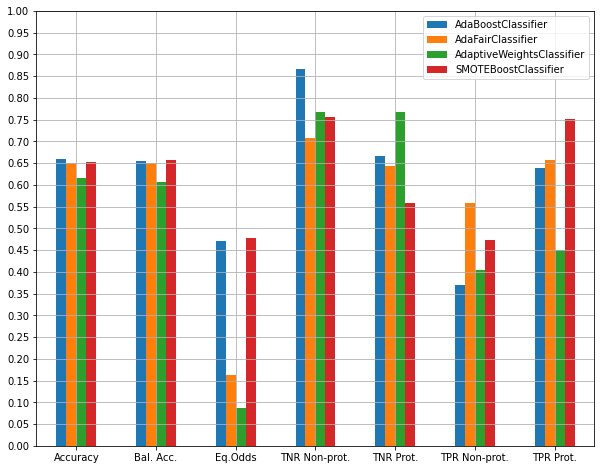

'Score Mean'

,Accuracy,Bal. Acc.,Eq.Odds,TNR Non-prot.,TNR Prot.,TPR Non-prot.,TPR Prot.
AdaBoostClassifier,0.659545,0.655613,0.470341,0.866436,0.666677,0.369275,0.639856
AdaFairClassifier,0.651220,0.650613,0.162364,0.708712,0.644299,0.559083,0.657035
AdaptiveWeightsClassifier,0.616780,0.605804,0.086783,0.768675,0.768219,0.404224,0.450363
SMOTEBoostClassifier,0.652683,0.656182,0.477990,0.757111,0.557562,0.473252,0.751693


'Score 2Std'

,Accuracy,Bal. Acc.,Eq.Odds,TNR Non-prot.,TNR Prot.,TPR Non-prot.,TPR Prot.
AdaBoostClassifier,0.017840,0.019017,0.185156,0.074062,0.046850,0.124381,0.048380
AdaFairClassifier,0.018630,0.017858,0.082993,0.160502,0.146284,0.158941,0.153872
AdaptiveWeightsClassifier,0.085094,0.092169,0.154413,0.489568,0.477985,0.601867,0.542682
SMOTEBoostClassifier,0.015422,0.015219,0.304991,0.129872,0.045141,0.116130,0.027167


In [15]:
# Plot and print results
compass_res = pd.read_csv("compass_res.csv", index_col=[0], header=[0, 1])
compass_plt = plotme(compass_res, skip_std='AdaptiveWeightsClassifier')
compass_plt.get_figure().savefig('compass_plt.pdf')

# Adult Census Income

In [21]:
# Load the data
data = AdultDataset()
dataset_name = type(data).__name__

# Define classifiers to test
classifiers = {
    type(clf).__name__: clf for clf in [
        base_clf,
        AdaFairClassifier(base_clf_af, n_est, eps=0),
        SMOTEBoostClassifier(base_clf_sb, 4, 20, 500),
        AdaptiveWeightsClassifier(base_clf_aw, data.objective),
    ]
}

# Split data
splits = rsfk.split(data.X, data.y)
n_splits = rsfk.get_n_splits()

# Create a dataframe to store the results
columns = pd.MultiIndex.from_product(
    [list(classifiers), list(get_scores(*[np.array([0])]*3))],
    names=["Classifier", "Score"],
)
res = pd.DataFrame(index=range(n_splits), columns=columns)

# Instanciate a progrees bar
pbar = tqdm(splits, total=n_splits)

for i, (train_index, test_index) in enumerate(pbar):

    # Get the splits
    X_train, X_test = data.X.iloc[train_index], data.X.iloc[test_index]
    y_train, y_test = data.y.iloc[train_index], data.y.iloc[test_index]
    s_train, s_test = data.sensitive.iloc[train_index], data.sensitive.iloc[test_index]

    for clf_name, clf in classifiers.items():

        # Fit the classifier
        try:
            clf.fit(X_train, y_train, sensitive=s_train)
        except TypeError:
            clf.fit(X_train, y_train)

        # Make predictions and compute scores
        y_pred = clf.predict(X_test)
        scores = get_scores(y_test, y_pred, s_test)

        # Store scores
        for score, value in scores.items():
            res.loc[i, (clf_name, score)] = value
        
        print(clf_name + ' finished')
    pbar.update(1)

adult_res = res.copy()
# Save results
adult_res.to_csv("adult_res.csv")

/Users/user/Documents/Skoltech/ML2021/ML_Final_Project/Fairness-Aware-Classification/fairness_aware_classification/metrics.py:246: RuntimeWarning: invalid value encountered in long_scalars
  score = tp / (tp + fn)
/Users/user/Documents/Skoltech/ML2021/ML_Final_Project/Fairness-Aware-Classification/fairness_aware_classification/metrics.py:277: RuntimeWarning: invalid value encountered in long_scalars
  score = tp / (tp + fn)
/Users/user/Documents/Skoltech/ML2021/ML_Final_Project/Fairness-Aware-Classification/fairness_aware_classification/metrics.py:339: RuntimeWarning: invalid value encountered in long_scalars
  score = tn / (tn + fp)
/Users/user/Documents/Skoltech/ML2021/ML_Final_Project/Fairness-Aware-Classification/fairness_aware_classification/metrics.py:159: RuntimeWarning: invalid value encountered in long_scalars
  * np.sum(~s) / np.sum(s)
  0%|          | 0/10 [00:00<?, ?it/s]/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarn

-0.9202773879928491
-1.1320361675111554
-1.2767690980113697
-1.4464395452839596
-1.6434930152104001
-1.7737019106057539
-1.602442425651531
-1.796987938313039
-1.7863251649814909
-1.8088660557167235
-1.7904887948095498
-1.815480183510244
-1.8135993479436543
-1.8145879413059771
-1.8133638857127043
-1.8133638857127043
-1.8143557260112488
-1.8145879413059771
-1.5746551159240885
-1.801104737708794
-1.6909020966010297
-1.7869987057179357
-1.7755725546535999
-1.8145136029322315
-1.7951764286329417
-1.8145136029322315
-1.8145136029322315
-1.8145136029322315
-1.8145136029322315
-1.8145136029322315
-1.8145136029322315
-1.8145136029322315
-1.8145136029322315
-1.4943526003416718
-1.698008093469267
-1.8146997699578984
-1.7689391728452173
-1.8146997699578984
-1.8144064220066336
-1.768807868216906
-1.79596923463731
-1.8056341627129635
-1.813694537876216
-1.8146787897459935
-1.8137133518156743


 10%|█         | 1/10 [02:50<25:31, 170.14s/it]/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://s

-1.1838721232648561
-1.1718237522730879
-1.2373108233075953
-1.2910312800563197
-1.3365108950138471
-1.3703522495581915
-1.3896137918621427
-1.407766367529157
-1.4200240854083328
-1.42413522225191
-1.4291803451770302
-1.4265776118260178
-1.4300641385589796
-1.4315139561572834
-1.432672300480725
-1.4329708981663898
-1.4329708981663898
-1.4329708981663898
-1.4329708981663898
-1.2746893527777319
-1.3860384690963876
-1.4761468959397086
-1.533257998531753
-1.5882844290549785
-1.6202283021802133
-1.6414874990079324
-1.6536527154362093
-1.6648006136530809
-1.6655823596682309
-1.6655823596682309
-1.6655823596682309
-1.6655823596682309
-1.6655823596682309
-1.6660171108284578
-1.6655823596682309
-1.6655823596682309
-1.6655823596682309
-1.7022071050387924
-1.3177164635136975
-1.6337999205853257
-1.7752786559778082
-1.7887771349555033
-1.8178398139644028
-1.8266318349138329
-1.8137000425168832
-1.8272877978814304
-1.825803917440738
-1.8256487193925706
-1.8272877978814304
-1.8272877978814304
-1.825

 30%|███       | 3/10 [05:08<11:07, 95.36s/it] 

-1.8272505932059941
Stored [0.99916353 0.99051393 1.00395311 1.09017863] for -1.8272505932059941


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

-0.9844422804886857
-1.0594785181993003
-1.14793751779826
-1.2487287348925993
-1.3531243745450037
-1.4683463982266818
-1.5698740370597974
-1.641534925290021
-1.7028178458627785
-1.7581273751129627
-1.7982851198720993
-1.7850327448792944
-1.7982851198720993
-1.7982851198720993
-1.7982851198720993
-1.741513344943535
-1.442768264018986


 50%|█████     | 5/10 [11:40<12:15, 147.08s/it]/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://s

-0.959320304012895
-0.9436561781772234
-0.9851780451434644
-1.030887879687103
-1.0888008389587918
-1.13393078827667
-1.1846982218497197
-1.2254981013466908
-1.2659000307287545
-1.3031018635360982
-1.3301782547030605
-1.346326473947701
-1.3516467183337708
-1.3572335079416287
-1.3557700747575085
-1.363295337316913
-1.363295337316913
-1.363295337316913
-1.363295337316913
-1.363295337316913
-1.363295337316913
-1.7723222551441098
-1.5919579567998687
-1.585296714762213
-1.8044054877483042
-1.7859754386283857
-1.7997259717803389
-1.8044054877483042
-1.8044054877483042
-1.8044054877483042
-1.8044054877483042
-1.8044054877483042
-1.8044054877483042
-1.8044054877483042
-1.8044054877483042
-1.4417714568600526
-1.7128934503186373
-1.4776953530222463
-1.7929949288321199
-1.661424124934832
-1.8042934701997138
-1.7779212162262419
-1.8055997176851246
-1.805715767562433
-1.8015196937191456
-1.805715767562433
-1.805715767562433
-1.805715767562433
-1.805715767562433
-1.805715767562433
-1.805715767562433


 60%|██████    | 6/10 [15:23<11:10, 167.60s/it]

-1.805763652588246
Stored [0.99835876 0.42984943 1.70441216 1.4670386 ] for -1.805763652588246


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

-1.4245265458274958
-1.3083451347501416
-1.4295603201706404
-1.5483055487991546
-1.6586188449366457
-1.7346527654032702
-1.8095741343545368
-1.8044043055818038
-1.8263651589526861
-1.8284724159408934
-1.8208433799783115
-1.8291162539602843
-1.8291162539602843
-1.8284600718031825
-1.8291162539602843
-1.8291162539602843
-1.8291162539602843
-1.8291162539602843
-1.3884237578655592
-1.6115281831035135
-1.7966733253237321
-1.7373909612513923
-1.8006046271373741
-1.8274381090468448
-1.7794804990861302
-1.8150467732328042
-1.8187223987962198
-1.827555285856111
-1.8261269349523888
-1.8291162539602843
-1.8261483828642484
-1.8291162539602843
-1.8291162539602843
-1.8291162539602843
-1.8291162539602843
-1.8291162539602843
-1.8291162539602843
-1.8291162539602843
-1.7533761053584098
-1.4373704551811197
-1.6438382279658184
-1.76417800464319
-1.800705652797629
-1.734556551383435
-1.8284724159408934
-1.8178182890333687
-1.8263651589526861
-1.8284724159408934
-1.8284724159408934
-1.8284724159408934
-1.82

 80%|████████  | 8/10 [24:25<07:04, 212.50s/it]

-1.8284912361662093
Stored [0.95314034 0.79577974 1.02041126 2.17157934] for -1.8284912361662093


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

-1.2161352449404006
-1.149368793146391
-1.249897834297953
-1.3534397810436931
-1.4419245311050637
-1.5538071041751753
-1.6187729113097555
-1.6757923181150765
-1.7173590513220898
-1.7480117825739228
-1.7733146104139932
-1.784153264974385
-1.797598078363397
-1.8036677002708532
-1.8046085877464946
-1.8055515286290182
-1.8046085877464946
-1.8046085877464946
-1.8046085877464946
-1.524378803022862
-1.7544168485417226
-1.7210165198090142
-1.7961876520953075
-1.8094513753369166
-1.7998478099016524
-1.8116391825272653
-1.8116391825272653
-1.8116391825272653
-1.8116391825272653
-1.8116391825272653
-1.8116391825272653
-1.685601260450917
-1.4258901096691796
-1.434121031711254
-1.7871152563861081
-1.6584504524667092
-1.8106901099285517
-1.7663929213563228
-1.8044791727982616
-1.8144506954560917
-1.802023380631744
-1.811613640867032
-1.8144506954560917
-1.8144506954560917
-1.8144506954560917
-1.8144506954560917
-1.8144506954560917
-1.7272222296877964
-1.7855730914997991
-1.6949154707492617
-1.804160

 90%|█████████ | 9/10 [28:00<03:33, 213.01s/it]

-1.8144506954560917
Stored [0.99862937 0.67481936 1.30635081 1.58319063] for -1.8144506954560917


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

-1.0484732753244341
-1.044183436705135
-1.1062460244519758
-1.162568208922032
-1.2185459589922978
-1.2721100041734286
-1.3140303351225702
-1.3525996621801082
-1.3710078330998177
-1.3831840301871767
-1.3930830582950944
-1.3983683799166866
-1.4056669421413324
-1.4077048173555684
-1.4075831111600565
-1.4081836603916509
-1.4061459953692217
-1.4075831111600565
-1.4086635205016815
-1.514902141591553
-1.7379555257854418
-1.7385101459960473
-1.8202186425598441
-1.8193758090326662
-1.7961305859931744
-1.815292874357302
-1.8202186425598441
-1.8202186425598441
-1.8202186425598441
-1.8202186425598441
-1.8202186425598441
-1.8202186425598441
-1.8202186425598441
-1.8202186425598441
-1.7808826781967344
-1.3882313366348848
-1.5032862991153988
-1.7964954603713663
-1.7365008537356807
-1.816449456849778
-1.8212175378405906
-1.8042212823402286
-1.8195419505424146
-1.8212175378405906
-1.8212175378405906
-1.8212175378405906
-1.8212175378405906
-1.718974698878827
-1.8146084864763905
-1.7334723291499694
-1.808

100%|██████████| 10/10 [32:31<00:00, 227.65s/it]

-1.8177402856622278
Stored [0.99827224 0.69950499 1.19386279 1.78560141] for -1.8177402856622278


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

-1.7001797638890643
-1.309255332901383
-1.4452425174301724
-1.5730935442590281
-1.6849415675159096
-1.7954364160489216
-1.786389084101316
-1.8149478931779102
-1.8242658636647802
-1.8134096359465204
-1.8249612067240422
-1.8249612067240422
-1.8249612067240422
-1.8249612067240422
-1.3330628937761309
-1.5160281884078546
-1.634618206044316
-1.7417669534669313
-1.806654750443537
-1.8046699149128163
-1.825686549356456
-1.825686549356456
-1.825686549356456
-1.825686549356456
-1.825686549356456
-1.825686549356456
-1.825686549356456
-1.825686549356456
-1.825686549356456
-1.803588816673512
-1.5305563305497971
-1.6203020677362299
-1.758316976140172
-1.7921068864791116
-1.8249298533683693
-1.8249231598582196
-1.825686549356456
-1.825686549356456
-1.825686549356456
-1.825686549356456
-1.8249231598582196
-1.825686549356456
-1.825686549356456
-1.825686549356456
-1.825686549356456
-1.825686549356456
-1.825686549356456
-1.825686549356456
-1.725142035074955
-1.7491923885062068
-1.6401573210776208
-1.8169

12it [36:19, 179.94s/it]                        

-1.825686549356456
Stored [0.9268136  0.92643638 1.10023504 1.52290013] for -1.825686549356456


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

-1.1461515933377486
-1.162343593011763
-1.1901190746262256
-1.2102369407600917
-1.2257987170038875
-1.236278670917215
-1.2408006557780957
-1.2454861507632624
-1.2471391212558613
-1.2490343220730262
-1.2485355509494764
-1.2486599743349038
-1.2496755259193735
-1.2496755259193735
-1.2477267065595101
-1.2496755259193735
-1.2478512881474475
-1.2478512881474475
-1.2496755259193735
-1.2496755259193735
-1.249550022156614
-1.2164890509372155
-1.3537998601333234
-1.4713916949373012
-1.57414696883944
-1.654056727311283
-1.7276853250879332
-1.7714982908233032
-1.8086804746741305
-1.8059506291609053
-1.8146133209486948
-1.8160983639236994
-1.8196377128163892
-1.8134951218950275
-1.8216301788921843
-1.8216301788921843
-1.820633080002855
-1.3081551820100135
-1.053580223221876
-1.5548812035333437
-1.723510428270715
-1.807271902596491
-1.7468409677368832
-1.8208484262783762
-1.7830577953382352
-1.8195685944993734
-1.821744809979663
-1.821262166945812
-1.821744809979663
-1.821744809979663
-1.82174480997

13it [43:23, 236.35s/it]/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/

-1.0156964706684473
-1.0157945594384028
-1.0285526594386765
-1.0379097668455135
-1.0446798233573145
-1.0476429789651887
-1.0511326949852593
-1.0520744501119452
-1.052310131449166
-1.0530308671504633
-1.0537799834352333
-1.0539572530107617
-1.0539572530107617
-1.0539572530107617
-1.0539572530107617
-1.0539572530107617
-1.0539572530107617
-1.0539572530107617
-1.0539572530107617
-1.152899789829548
-1.2952217094540996
-1.3951637083883186
-1.4785832284657312
-1.550610662953848
-1.6113013860529168
-1.6521942549722743
-1.6690297297587304
-1.6865539511934364
-1.698867049514352
-1.7052068394786744
-1.712297042154936
-1.7167922126683175
-1.7189239963180136
-1.7202424558704703
-1.7202424558704703
-1.7202424558704703
-1.7202424558704703
-1.7202424558704703
-1.4488433289255804
-1.1695596617951394
-1.6859178033943973
-1.8080970470384257
-1.716074684377277
-1.8264301000907879
-1.7699655730046682
-1.819272576345913
-1.8307560577422206
-1.8218312500103457
-1.8319745378084624
-1.8324851366715182


100%|██████████| 10/10 [46:02<00:00, 276.22s/it]


#### Read saved csv and plot results

/Users/user/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:890: FutureWarning: The 'tupleize_cols' argument has been deprecated and will be removed in a future version. Column tuples will then always be converted to MultiIndex.


  self.options, self.engine = self._clean_options(options, engine)


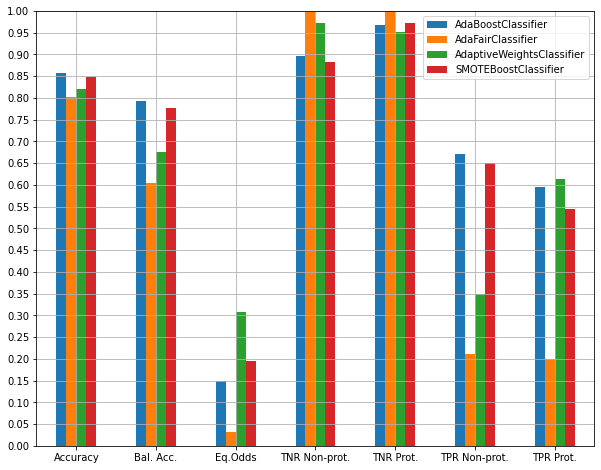

'Score Mean'

,Accuracy,Bal. Acc.,Eq.Odds,TNR Non-prot.,TNR Prot.,TPR Non-prot.,TPR Prot.
AdaBoostClassifier,0.858119,0.792136,0.148645,0.895829,0.968237,0.672046,0.595809
AdaFairClassifier,0.801757,0.603472,0.032075,0.997746,0.999306,0.210209,0.199539
AdaptiveWeightsClassifier,0.821026,0.676515,0.308059,0.972229,0.951497,0.349366,0.613165
SMOTEBoostClassifier,0.847192,0.776375,0.195287,0.883148,0.972647,0.650983,0.545195


'Score 2Std'

,Accuracy,Bal. Acc.,Eq.Odds,TNR Non-prot.,TNR Prot.,TPR Non-prot.,TPR Prot.
AdaBoostClassifier,0.003926,0.006224,0.027544,0.008084,0.006285,0.014697,0.033544
AdaFairClassifier,0.014022,0.031345,0.024508,0.005028,0.001489,0.069638,0.070651
AdaptiveWeightsClassifier,0.025538,0.084755,0.198180,0.042907,0.069315,0.219599,0.283185
SMOTEBoostClassifier,0.003489,0.006834,0.031907,0.009563,0.003580,0.019354,0.023754


In [22]:
# Plot and print results
adult_res = pd.read_csv("adult_res.csv", index_col=[0], header=[0, 1])
adult_plt = plotme(adult_res, skip_std='AdaptiveWeightsClassifier')
adult_plt.get_figure().savefig('adult_plt.pdf')

# Bank Marketing

In [ ]:
# Load the data
data = BankDataset()
dataset_name = type(data).__name__

# Define classifiers to test
classifiers = {
    type(clf).__name__: clf for clf in [
        base_clf,
        AdaFairClassifier(base_clf_af, n_est, eps=0),
        SMOTEBoostClassifier(base_clf_sb, 4, 20, 500),
        AdaptiveWeightsClassifier(base_clf_aw, data.objective),
    ]
}

# Split data
splits = rsfk.split(data.X, data.y)
n_splits = rsfk.get_n_splits()

# Create a dataframe to store the results
columns = pd.MultiIndex.from_product(
    [list(classifiers), list(get_scores(*[np.array([0])]*3))],
    names=["Classifier", "Score"],
)
res = pd.DataFrame(index=range(n_splits), columns=columns)

# Instanciate a progrees bar
pbar = tqdm(splits, total=n_splits)

for i, (train_index, test_index) in enumerate(pbar):

    # Get the splits
    X_train, X_test = data.X.iloc[train_index], data.X.iloc[test_index]
    y_train, y_test = data.y.iloc[train_index], data.y.iloc[test_index]
    s_train, s_test = data.sensitive.iloc[train_index], data.sensitive.iloc[test_index]

    for clf_name, clf in classifiers.items():

        # Fit the classifier
        try:
            clf.fit(X_train, y_train, sensitive=s_train)
        except TypeError:
            clf.fit(X_train, y_train)

        # Make predictions and compute scores
        y_pred = clf.predict(X_test)
        scores = get_scores(y_test, y_pred, s_test)

        # Store scores
        for score, value in scores.items():
            res.loc[i, (clf_name, score)] = value
            
        print(clf_name + ' finished')
    pbar.update(1)

bank_res = res.copy()
# Save results
bank_res.to_csv("bank_res.csv")

/Users/user/Documents/Skoltech/ML2021/ML_Final_Project/Fairness-Aware-Classification/fairness_aware_classification/metrics.py:246: RuntimeWarning: invalid value encountered in long_scalars
  score = tp / (tp + fn)
/Users/user/Documents/Skoltech/ML2021/ML_Final_Project/Fairness-Aware-Classification/fairness_aware_classification/metrics.py:277: RuntimeWarning: invalid value encountered in long_scalars
  score = tp / (tp + fn)
/Users/user/Documents/Skoltech/ML2021/ML_Final_Project/Fairness-Aware-Classification/fairness_aware_classification/metrics.py:339: RuntimeWarning: invalid value encountered in long_scalars
  score = tn / (tn + fp)
/Users/user/Documents/Skoltech/ML2021/ML_Final_Project/Fairness-Aware-Classification/fairness_aware_classification/metrics.py:159: RuntimeWarning: invalid value encountered in long_scalars
  * np.sum(~s) / np.sum(s)
  0%|          | 0/10 [00:00<?, ?it/s]/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarn

-1.2141994813460246
-1.2167188894843142
-1.1323294951744727
-1.2624969113937516
-1.301994266415924
-1.3239773706597906
-1.338500035865053
-1.3462767786652103
-1.34949159837561
-1.352527702357974
-1.3550381596385126
-1.3564569477844493
-1.3564569477844493
-1.3560685823827932
-1.3569069166182648
-1.3576798160793768
-1.3576798160793768
-1.3576798160793768
-1.3576798160793768
-1.3576798160793768
-1.3576798160793768


 50%|█████     | 5/10 [14:06<15:15, 183.03s/it]/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://s

-1.0504088096838784
-1.646791307629626
-1.856292680340907
-1.5135177417892283
-1.8274733962353717
-1.7549141842274292
-1.8948957973852605
-1.8904867174977706
-1.8930761260651034
-1.8942959379458757
-1.8948957973852605
-1.8948957973852605
-1.8948957973852605
-1.8948957973852605
-1.8948957973852605
-1.8948957973852605
-1.7571466080852605
-1.8631203420849927
-1.8879451100054458
-1.8735342275114486
-1.8949687020690928
-1.8799561423713052
-1.8949687020690928
-1.8949687020690928
-1.8949687020690928
-1.8949687020690928
-1.8949687020690928
-1.8949687020690928
-1.8949687020690928
-1.8949687020690928
-1.8949687020690928
-1.8949687020690928
-1.8949687020690928
-1.6516248863527117
-1.7296202906495433
-1.8713532446537702


 60%|██████    | 6/10 [21:08<16:28, 247.16s/it]/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://s

-1.7561977105706936
-1.8592277773135932
-1.60051916881355
-1.6627226686451657
-1.9004556833480917
-1.796001040054672
-1.8862271782042024
-1.8927006107895181
-1.8992828127302204
-1.8992828127302204


 80%|████████  | 8/10 [27:15<07:19, 219.60s/it]/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://s

-1.3196943932598568
-1.2160539298045878
-1.1172251783524472
-1.2782239601364647
-1.3248169834592383
-1.3532345612524987
-1.3740216595753896
-1.3886857212722878
-1.399131495208617
-1.4042276392576543
-1.407542229990932
-1.4104725491436025
-1.4121282744936536
-1.4126382605498788
-1.4144241201469594
-1.4151858507851744
-1.4155667161042818
-1.4155667161042818
-1.4155667161042818
-1.4155667161042818


100%|██████████| 10/10 [44:41<00:00, 369.03s/it]/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://

-1.6115944960573587
-1.658758484691087
-1.8485931238008462
-1.5513221241713913
-1.8359017964367457
-1.8573178406269029
-1.885216445984073
-1.8869642650222107
-1.885326916104531
-1.8975050942935099
-1.8975050942935099
-1.8975050942935099
-1.8895786851538876
-1.8911688428338305
-1.8940197020174114
-1.8957595747605822
-1.8957595747605822
-1.8975050942935099
-1.8963324326872169
-1.8951507964290757
-1.8963324326872169
-1.8951507964290757
-1.8994059185094452
-1.8994059185094452
-1.8975050942935099
-1.8979788204372765
-1.8979788204372765
-1.8979788204372765
-1.8994059185094452
-1.8994059185094452
-1.8979788204372765
-1.8994059185094452
-1.8994059185094452
-1.8994059185094452
-1.8994059185094452
-1.8979788204372765
-1.715626472135027
-1.859492980572317
-1.797727462968545
-1.855432936332463
-1.8975050942935099
-1.8696471174012743
-1.8975050942935099
-1.8975050942935099
-1.8975050942935099
-1.8975050942935099
-1.8975050942935099
-1.8975050942935099
-1.8975050942935099
-1.8975050942935099
-1.8933

12it [49:57, 280.70s/it]                        

-1.8989427354697472
Stored [0.58443571 0.41579515 2.0029817  1.05505062] for -1.8989427354697472


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

-1.855058223760892
-1.8700815788280587
-1.8948450116259261
-1.8753203517416344
-1.8920615635429048
-1.8948450116259261
-1.8948450116259261
-1.8948450116259261
-1.8926430797396736
-1.8948450116259261
-1.8948450116259261
-1.8948450116259261
-1.8948450116259261
-1.8948450116259261
-1.8948450116259261
-1.8948450116259261
-1.8948450116259261
-1.8948450116259261
-1.6615990994434786
-1.5469849154859572
-1.7804842660940654
-1.8724950477611308
-1.8487603009069309
-1.8813933802630847
-1.901556558286737
-1.888840188844096
-1.901556558286737
-1.901556558286737
-1.901556558286737
-1.884204116281044
-1.692423024003008
-1.8574695473371912
-1.8964726094249134
-1.890893312769451
-1.8991477377146933
-1.891300772910614
-1.8991477377146933
-1.8991477377146933
-1.8991477377146933
-1.8991477377146933
-1.8991477377146933
-1.8991477377146933
-1.8991477377146933
-1.8991477377146933
-1.6689690458486464
-1.5700866996588712
-1.8780882962339185
-1.7760568518162136
-1.8718180808214804
-1.8893215159306855
-1.8484939

13it [51:42, 240.11s/it]

-1.870578678913519
Stored [0.61791885 0.13061743 1.0521813  0.73683451] for -1.870578678913519


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

-1.7636898951032858
-1.78553751421572
-1.8541185995143028


#### Read saved csv and plot results


/Users/user/anaconda3/lib/python3.6/site-packages/pandas/io/parsers.py:890: FutureWarning: The 'tupleize_cols' argument has been deprecated and will be removed in a future version. Column tuples will then always be converted to MultiIndex.


  self.options, self.engine = self._clean_options(options, engine)


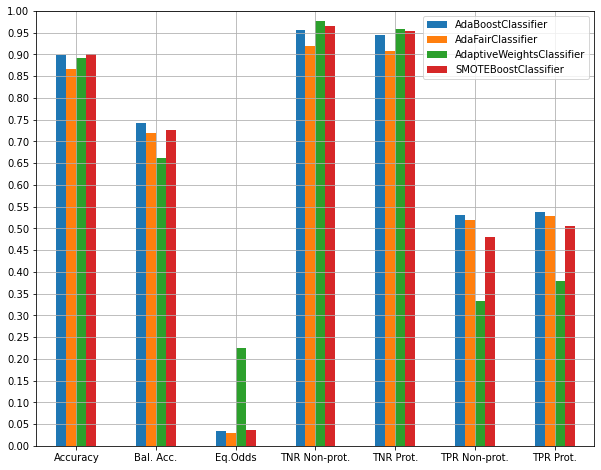

'Score Mean'

,Accuracy,Bal. Acc.,Eq.Odds,TNR Non-prot.,TNR Prot.,TPR Non-prot.,TPR Prot.
AdaBoostClassifier,0.898813,0.742828,0.035028,0.956880,0.944525,0.530284,0.538312
AdaFairClassifier,0.865442,0.719231,0.028829,0.920301,0.907700,0.519759,0.527579
AdaptiveWeightsClassifier,0.891721,0.662634,0.224591,0.977627,0.958069,0.333363,0.379961
SMOTEBoostClassifier,0.901515,0.726538,0.036300,0.965402,0.954515,0.480440,0.505854


'Score 2Std'

,Accuracy,Bal. Acc.,Eq.Odds,TNR Non-prot.,TNR Prot.,TPR Non-prot.,TPR Prot.
AdaBoostClassifier,0.002506,0.008695,0.032070,0.004381,0.004757,0.032927,0.029886
AdaFairClassifier,0.158167,0.080716,0.028025,0.225342,0.234788,0.355203,0.363528
AdaptiveWeightsClassifier,0.012492,0.140939,0.440833,0.027165,0.083162,0.305679,0.523783
SMOTEBoostClassifier,0.002607,0.007713,0.041753,0.003141,0.006349,0.018121,0.030869


In [24]:
# Plot and print results
bank_res = pd.read_csv("bank_res.csv", index_col=[0], header=[0, 1])
bank_plt = plotme(bank_res, skip_std='AdaptiveWeightsClassifier')
bank_plt.get_figure().savefig('bank_plt.pdf')

# KDD Census Income

In [29]:
# Load the data
data = KDDDataset()
dataset_name = type(data).__name__

# Define classifiers to test
classifiers = {
    type(clf).__name__: clf for clf in [
        base_clf,
        AdaFairClassifier(base_clf_af, n_est, eps=0),
        SMOTEBoostClassifier(base_clf_sb, 4, 20, 500),
        AdaptiveWeightsClassifier(base_clf_aw, data.objective),
    ]
}

# Split data
splits = rsfk.split(data.X, data.y)
n_splits = rsfk.get_n_splits()

# Create a dataframe to store the results
columns = pd.MultiIndex.from_product(
    [list(classifiers), list(get_scores(*[np.array([0])]*3))],
    names=["Classifier", "Score"],
)
res = pd.DataFrame(index=range(n_splits), columns=columns)

# Instanciate a progrees bar
pbar = tqdm(splits, total=n_splits)

for i, (train_index, test_index) in enumerate(pbar):

    # Get the splits
    X_train, X_test = data.X.iloc[train_index], data.X.iloc[test_index]
    y_train, y_test = data.y.iloc[train_index], data.y.iloc[test_index]
    s_train, s_test = data.sensitive.iloc[train_index], data.sensitive.iloc[test_index]

    for clf_name, clf in classifiers.items():

        # Fit the classifier
        try:
            clf.fit(X_train, y_train, sensitive=s_train)
        except TypeError:
            clf.fit(X_train, y_train)

        # Make predictions and compute scores
        y_pred = clf.predict(X_test)
        scores = get_scores(y_test, y_pred, s_test)

        # Store scores
        for score, value in scores.items():
            res.loc[i, (clf_name, score)] = value
            
        print(clf_name + ' finished')

    pbar.update(1)

kdd_res = res.copy()
# Save results
kdd_res.to_csv("kdd_res.csv")

/Users/user/Documents/Skoltech/ML2021/ML_Final_Project/Fairness-Aware-Classification/fairness_aware_classification/metrics.py:246: RuntimeWarning: invalid value encountered in long_scalars
  score = tp / (tp + fn)
/Users/user/Documents/Skoltech/ML2021/ML_Final_Project/Fairness-Aware-Classification/fairness_aware_classification/metrics.py:277: RuntimeWarning: invalid value encountered in long_scalars
  score = tp / (tp + fn)
/Users/user/Documents/Skoltech/ML2021/ML_Final_Project/Fairness-Aware-Classification/fairness_aware_classification/metrics.py:339: RuntimeWarning: invalid value encountered in long_scalars
  score = tn / (tn + fp)
/Users/user/Documents/Skoltech/ML2021/ML_Final_Project/Fairness-Aware-Classification/fairness_aware_classification/metrics.py:159: RuntimeWarning: invalid value encountered in long_scalars
  * np.sum(~s) / np.sum(s)
  0%|          | 0/10 [00:00<?, ?it/s]

AdaBoostClassifier finished
AdaFairClassifier finished


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

SMOTEBoostClassifier finished
-0.9893030392837445
-1.0019669889088567


 10%|█         | 1/10 [27:35<4:08:19, 1655.48s/it]

AdaptiveWeightsClassifier finished
AdaBoostClassifier finished
AdaFairClassifier finished


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

SMOTEBoostClassifier finished
-1.0198941182937462
-1.0172594245835123
-1.0096412485800779
-1.0201658413962646
-1.0215115854651515
-1.0222821336790915
-1.0237438594608084
-1.0244339311444768
-1.0245514332509364
-1.0243915860745016
-1.0253219814648764
-1.0254026473376479
-1.0253603022676727
-1.0252837559276333
-1.02487773145254
-1.0251990657876828
-1.0253219814648764
-1.0249670140380043
-1.0252414108576582
-1.0253219814648764
-1.0254834087053435
-1.0253643265348518
-1.0487236789463472
-1.0363166398188874
-1.0586967895035477
-1.0666713159185814
-1.075630904033563
-1.0801651738827898
-1.0823593584845117
-1.083830328835952
-1.0853336710684616
-1.083820918234698
-1.084906827739718
-1.0853336710684616
-1.084906827739718
-1.084906827739718
-1.0852913259984867
-1.0850987370256877
-1.0850987370256877
-1.0854845979153995
-1.0855269429853749
-1.0850987370256877
-1.0850987370256877
-1.2817032455955388
-1.8966392769818161
-1.4212965191567368
-1.8339400618351012
-1.8325542690930523
-1.930897767274304

 30%|███       | 3/10 [38:53<1:19:21, 680.26s/it] 

AdaptiveWeightsClassifier finished
AdaBoostClassifier finished
AdaFairClassifier finished


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

SMOTEBoostClassifier finished
-1.55362528415734


 50%|█████     | 5/10 [45:36<36:11, 434.23s/it]  

AdaptiveWeightsClassifier finished
AdaBoostClassifier finished
AdaFairClassifier finished


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

SMOTEBoostClassifier finished
-1.0200382452074042
-1.013113309235887
-0.9906197286989831
-1.028761749166795
-1.0527526417873303
-1.0622649104753712
-1.0670438919999117
-1.0712539970102632
-1.0731224572204474
-1.073919229275589
-1.0778321147896197
-1.0787212766107193
-1.0788390867611648
-1.0795687419161402
-1.0808803664714628
-1.0815785238190994
-1.0815785238190994
-1.0815785238190994
-1.0815027014540293
-1.0818152850403995
-1.0815785238190994
-1.0815027014540293


 60%|██████    | 6/10 [1:17:36<55:33, 833.30s/it]

AdaptiveWeightsClassifier finished
AdaBoostClassifier finished
AdaFairClassifier finished


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

SMOTEBoostClassifier finished
-1.0488274425879338
-1.0973365814857723
-1.0709825845492176
-1.1194500625951758
-1.1289505206338188
-1.14046010171761
-1.144968708668494
-1.1502047778439621
-1.151406682571419
-1.151406682571419
-1.151406682571419
-1.1505708435654811
-1.1493700775822107
-1.151406682571419
-1.151406682571419
-1.1534432875606275
-1.151406682571419
-1.151406682571419
-1.0650563381828058
-1.0308030467487543
-1.1014915595030796
-1.1366941484165443
-1.1721070203221828
-1.2040287336642619
-1.230091176201043
-1.258172663508616
-1.2699407660734354
-1.2790389073670008
-1.2884384015381833
-1.2921187137020516
-1.300741226403547
-1.300741226403547


 80%|████████  | 8/10 [1:28:29<20:26, 613.19s/it]

AdaptiveWeightsClassifier finished
AdaBoostClassifier finished
AdaFairClassifier finished


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

SMOTEBoostClassifier finished
-1.1229620146894252
-1.1249361463016188
-1.1248938012316438
-1.1248938012316438
-1.1248938012316438
-1.1235870418491014
-1.1248938012316438
-1.1248938012316438
-1.1248938012316438
-1.126220064485567
-1.1235870418491014
-1.1235870418491014
-1.1242168380102142
-1.1248938012316438
-1.1242591830801894
-1.1229620146894252
-1.1242168380102142
-1.1255332951502832
-1.1248938012316438


 90%|█████████ | 9/10 [1:37:15<09:52, 592.57s/it]

AdaptiveWeightsClassifier finished
AdaBoostClassifier finished
AdaFairClassifier finished


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

SMOTEBoostClassifier finished
-0.9987413743441484
-1.0183497948895464
-1.0091142307091319
-1.0260975578020854
-1.028886750122927
-1.0317867750147454
-1.0351367308120087
-1.0370463519340054
-1.0393423347657704
-1.0401862941183189
-1.0423633466549886
-1.0433262363026323


100%|██████████| 10/10 [1:44:23<00:00, 550.95s/it]

AdaptiveWeightsClassifier finished
AdaBoostClassifier finished
AdaFairClassifier finished


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

SMOTEBoostClassifier finished
-1.076784252792657
-1.0782242229238328


12it [1:46:43, 349.19s/it]                        

AdaptiveWeightsClassifier finished
AdaBoostClassifier finished
AdaFairClassifier finished


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

SMOTEBoostClassifier finished
-0.9806733678300321
-0.9723930413526852
-0.968438877258209
-0.9752737618952838
-0.9773402603566846
-0.978456926834672
-0.9807085538746678
-0.9806733678300321
-0.9806733678300321
-0.9799910142582124


13it [1:53:49, 367.06s/it]

AdaptiveWeightsClassifier finished
AdaBoostClassifier finished
AdaFairClassifier finished


/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/user/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

SMOTEBoostClassifier finished
-0.9310890357232875


100%|██████████| 10/10 [1:56:06<00:00, 696.67s/it]

AdaptiveWeightsClassifier finished


Classifier                 Score        
AdaBoostClassifier         Accuracy         0.955614
                           Bal. Acc.        0.720289
                           Eq.Odds          0.302596
                           TPR Prot.        0.513397
                           TPR Non-prot.    0.232753
                           TNR Prot.        0.974423
                           TNR Non-prot.    0.996375
                           objective        1.080571
AdaFairClassifier          Accuracy         0.948223
                           Bal. Acc.        0.560890
                           Eq.Odds          0.034834
                           TPR Prot.        0.130364
                           TPR Non-prot.    0.095945
                           TNR Prot.        0.998439
                           TNR Non-prot.    0.998854
                           objective        1.192121
SMOTEBoostClassifier       Accuracy         0.950780
                           Bal. Acc.        0.644799
     

#### Read saved csv and plot results


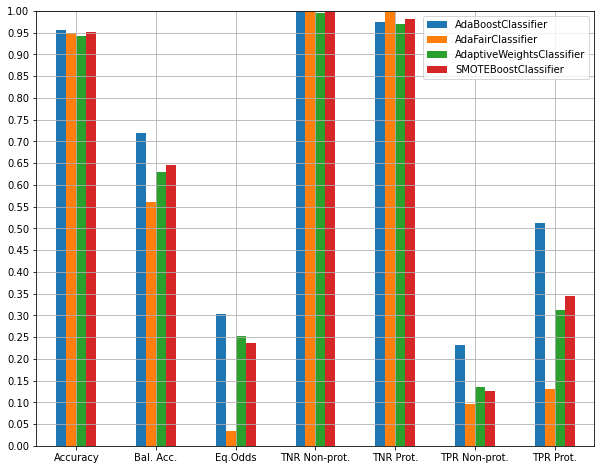

'Score Mean'

,Accuracy,Bal. Acc.,Eq.Odds,TNR Non-prot.,TNR Prot.,TPR Non-prot.,TPR Prot.
AdaBoostClassifier,0.955614,0.720289,0.302596,0.996375,0.974423,0.232753,0.513397
AdaFairClassifier,0.948223,0.560890,0.034834,0.998854,0.998439,0.095945,0.130364
AdaptiveWeightsClassifier,0.943461,0.630029,0.253345,0.996270,0.970233,0.135156,0.313171
SMOTEBoostClassifier,0.950780,0.644799,0.237403,0.998483,0.981432,0.125039,0.345391


'Score 2Std'

,Accuracy,Bal. Acc.,Eq.Odds,TNR Non-prot.,TNR Prot.,TPR Non-prot.,TPR Prot.
AdaBoostClassifier,0.002011,0.013281,0.053755,0.001255,0.003634,0.034837,0.036147
AdaFairClassifier,0.000883,0.006742,0.018070,0.000228,0.000291,0.015402,0.015649
AdaptiveWeightsClassifier,0.026793,0.163100,0.542080,0.012698,0.107694,0.179026,0.472974
SMOTEBoostClassifier,0.001757,0.012316,0.045444,0.000692,0.003957,0.038316,0.032034


In [30]:
# Plot and print results
kdd_res = pd.read_csv("kdd_res.csv", index_col=[0], header=[0, 1])
kdd_plt = plotme(kdd_res, skip_std='AdaptiveWeightsClassifier')
kdd_plt.get_figure().savefig('kdd_plt.pdf')